<center>
        <div style="font-size: 40px; color: black"><b>Extraction of 3D information from binocular images</b></div>
</center>

EPPS Training School 12.09.2025

Samuel Thomas - R&D signal & image processing engineer - team Cigale, Arvalis (s.thomas@arvalis.fr)
Part of the LPA CAPTE

licensed under CC By NC 4.0

# Part 2 : 3D reconstruction of a scene from a stereo pair of images

In this notebook, you will find the code with the main required steps for making a depth map, and a simple estimation of the height 

### 📌 Documentation may be found here :

From OpenCV :

[stereoRectify](./documentation/OpenCV_stereoRectify.pdf)

[initUndistortRectifyMap](./documentation/OpenCV_initUndistortRectifyMap.pdf)

[remap](./documentation/OpenCV_remap.pdf)

[StereoSGBM](./documentation/OpenCV_StereoSGBM_create.pdf)

https://docs.opencv.org/4.x/d9/db7/tutorial_py_table_of_contents_calib3d.html

https://learnopencv.com/depth-perception-using-stereo-camera-python-c/

In [90]:
import os
import numpy as np
import cv2 as cv
import open3d as o3d
import laspy
import matplotlib.pyplot as plt
from pathlib import Path
from IPython import display
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

import stereolib

### 📌 References to the open3d project (Zhou2018) :

&nbsp;
Authors : Qian-Yi Zhou and Jaesik Park and Vladlen Koltun. (2018)

&nbsp;
Title : Open3D : A Modern Library for 3D Data Processing

&nbsp;
Journal : arXiv:1801.09847

# Prerequisites

## 1.  Loading the calibration data

In [91]:
# Path to the data directory
path_data = Path("./data")

# Load calibration matrices and vectors
calibration_path = path_data / Path("calibration") / Path("literal_v2")

# Calibration path for Literal v2    
calibration_filename = calibration_path / "Tricam.yaml"

# If this file exists, then load calibration from its content
if os.path.exists(calibration_filename):

    img_size_left, camera_mtx_left, dist_coefs_left, \
    img_size_right, camera_mtx_right, dist_coefs_right, \
    R_pair, T_pair, \
    serial_number, \
    calibration_datetime = stereolib.load_calibration_from_yaml(calibration_filename)

# Calibration has to be loaded from files previously generated with calibration.ipynb, from chessboard images
else:
    
    img_size_left, camera_mtx_left, dist_coefs_left, \
    img_size_right, camera_mtx_right, dist_coefs_right, \
    R_pair, T_pair = stereolib.load_calibration_from_numpy(calibration_path)
    

Serial number : 444302
Calibration date : 2024-11-06 10-04-59 

Left camera
Distortion model : PERSPECTIVE
Mean reprojection error : 0.2874501049518585 

Right camera
Distortion model : PERSPECTIVE
Mean reprojection error : 0.2875809967517853 

Stereo RGB pair
Mean reprojection error : 0.3562925457954407 



## 2.  Preparing the data

In [92]:
# Paths for our input images
path_rgb_images = path_data / Path("inputs")

# Elements composing the name of our images
name_base_camera = "Tricam1Camera"
left_id = 1
right_id = 2
plot_id = "556-A"
image_id = "1"
image_ext = "png"

# Name of the pair of images used
name_img_left = path_rgb_images / f"Plot{plot_id}_{name_base_camera}{left_id}_{image_id}.{image_ext}"
name_img_right = path_rgb_images / f"Plot{plot_id}_{name_base_camera}{right_id}_{image_id}.{image_ext}"

# Load left and right input images
img_left = stereolib.read_image(name_img_left)
img_right = stereolib.read_image(name_img_right)

# Paths for generated outputs
path_outputs = path_data / Path("outputs")
if os.path.isdir(path_outputs) is False:
            os.mkdir(path_outputs)

### Input images :

Left and right RGB raw images

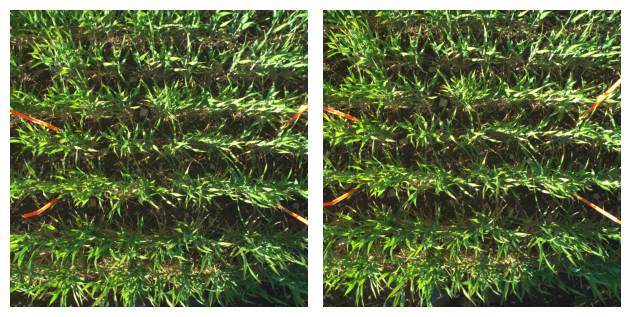

In [93]:
stereolib.display_images([name_img_left, name_img_right])

# Step 1 : Rectifying the images

This could be done during the calibration process, but as those maps are big matrices (in our case, from 30 to 60 Mb each), we prefer doing this at the beggining of the reconstruction part, as it's done once and does not take too much time.

Reminder : starting with the original 'raw' images, the objective of this stage is to get rectified left and right images, i.e. the left and right projective planes are coplanar and their rows are perfectly aligned :

<img src="static/stereo_rectification.png" width="300"/>

## 1.  Generating the rectification maps

In [94]:
# Get the transformation matrices for rectification, from the intrinsic and distorsion parameters of each camera, 
# and rotation and translation matrices describing related positions of left and right cameras (coming from stereo calibration)
R_rect_left, R_rect_right, \
P_rect_left, P_rect_right, \
Q_rect_left, \
valid_pix_roi_1, valid_pix_roi_2  = cv.stereoRectify(camera_mtx_left,
                                                     dist_coefs_left,
                                                     camera_mtx_right,
                                                     dist_coefs_right,
                                                     img_size_left,
                                                     R_pair,
                                                     T_pair)

# We compute the maps (offset along rows and columns) to be applied to each pixel of each camera image (left and right), so that the left and right images
# are rectified (= lines of the two cameras are aligned)
# Left camera
map_left_1, map_left_2 = cv.initUndistortRectifyMap(camera_mtx_left,
                                                    dist_coefs_left,
                                                    R_rect_left,
                                                    P_rect_left,
                                                    img_size_left,
                                                    cv.CV_16SC2)

# Right camera
map_right_1, map_right_2 = cv.initUndistortRectifyMap(camera_mtx_right,
                                                      dist_coefs_right,
                                                      R_rect_right,
                                                      P_rect_right,
                                                      img_size_right,
                                                      cv.CV_16SC2)

# Distance between the two cameras, in mm. Expressed in mm, because at the calibration step, we specified the chessboard cell size in millimeters.
# This is simply computed considering the norm of the translation vector resulting of the stereo calibration pair.
baseline = np.linalg.norm(T_pair)

# Focal length obtained after rectification, expressed in pixels 
focal_length = P_rect_left[0][0]

### Outputs :

In [95]:
print(f"baseline = {baseline} mm")
print(f"focal length = {focal_length} pixels")

baseline = 60.260691202703086 mm
focal length = 5057.804469493889 pixels


## 2.  Applying the rectification maps to the input image pairs

At this step, we have to apply the correction maps computed for each camera at the beginning to each of our left and right input images

In [96]:
# Rectify both images, so that the lines of the left image are matching those in the right image.
rect_img_left = stereolib.rectify(img_left, map_left_1, map_left_2)
rect_img_right = stereolib.rectify(img_right, map_right_1, map_right_2)

# Save those images
name_rect_img_left = path_outputs / "rect_left_image.png"
name_rect_img_right = path_outputs / "rect_right_image.png"

stereolib.write_image(name_rect_img_left, rect_img_left)
stereolib.write_image(name_rect_img_right, rect_img_right)

# We store height and width of the left image for further use
height, width = rect_img_left.shape[:2]

### Outputs :

Rectifed left and right images

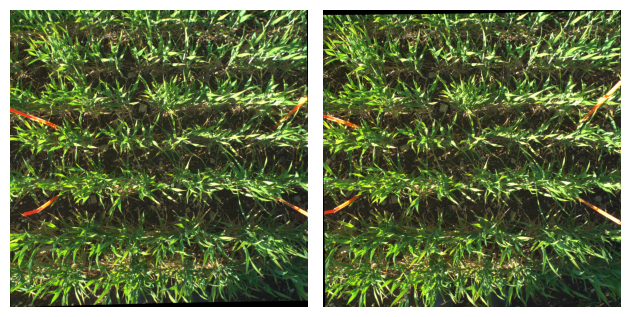

In [97]:
stereolib.display_images([name_rect_img_left, name_rect_img_right])

### For the rectification operation, we chose to keep the original image size : you can observe that both left and right images were slightly tilted, black pixels added at the bottom of the left, and at the top and left of the right image.
You could also try to play with the parameters in stereolib.rectify and see the way in which this influences the rectified images (and the use of the ROI)

In [98]:
print(f"Rectified left image shape = {rect_img_left.shape}")

Rectified left image shape = (3100, 3100, 3)


# Step 2 : Computing the matching correspondence between the left and right images

At the end of this stage, the aim is to retrieve a disparity value for each pixel of the reference image (say the left one)

The expected disparity map is a 1-channel image of the same size as the left image, in which a pixel value encodes the distance in pixels of the counterpart right pixel on the same row

### The OpenCV Semi Global Block Matching (SGBM) algorithm
- Works on rectified left and right images, RGB or grayscale (RGB is more demanding on input  ; quality but may be in this case more accurate)
- Needs to predefine the minimal disparity and number of disparities we want to search for (i.e. the distance range of our objects in the image) => A good choice is important for relevance and computation time
- Works by considering the neighborhood of each pixel in several directions (more accuracy/lower speed)

<img src="static/stereo_matching.png" width="800"/>

In [99]:
# Range of depth_image in which something is interesting (depending on one's application), in mm
range_operating_depth = [1200, 2800]

# We compute disparities corresponding to the given range
min_disparity_init = int(stereolib.compute_disparity_from_depth(baseline, focal_length, range_operating_depth[1]))

# Prohibits the '0' value (would lead to infinite depth_image as Z = (baseline * focal_length) / disparity)
min_disparity_init = max(min_disparity_init, 1)
min_disparity_init = int(min_disparity_init)

# Rounds to upper digit to ensure to matching the desired value
max_disparity_init = int(stereolib.compute_disparity_from_depth(baseline, focal_length, range_operating_depth[0])) + 1

# We compute the number of disparities (must be a multiple of 16)
num_disparities_init = stereolib.compute_number_of_disparities(min_disparity_init, max_disparity_init)

# Convert RGB images to grayscale for matching (not mandatory, may work with RGB images, but more demanding in terms of computation power and of quality of the input images)
rect_gray_img_left = cv.cvtColor(rect_img_left, cv.COLOR_BGR2GRAY)
rect_gray_img_right = cv.cvtColor(rect_img_right, cv.COLOR_BGR2GRAY)

# As images are rectified and both lines aligned, you may choose to downsample images along lines to reduce processing time and CPU charge
# (dependending on the resolution and objects size)
# Here for example we downsample by a 4 factor
factor_dwns = 4
rect_gray_img_left_dwns = np.copy(rect_gray_img_left[::factor_dwns, ...])
rect_gray_img_right_dwns = np.copy(rect_gray_img_right[::factor_dwns, ...])

# Parameters for filtering the disparity (/!\ : good rendering but may lead to approximations in distances). We don't activate filtering by default.
wls_activation = False
wls_sigma = 1.2

# We compute the disparity using for SGBM algorithm, with efficient parameters (for our application and from our experience)
ret, disparity_map_dwns, min_disparity, max_disparity = stereolib.stereo_processing(rect_gray_img_left_dwns,
                                                                                    rect_gray_img_right_dwns,
                                                                                    Q_rect_left,
                                                                                    min_disparity_init,
                                                                                    num_disparities_init,
                                                                                    block_size=3,
                                                                                    uniqueness_ratio=1,
                                                                                    wls_activation=False,
                                                                                    wls_sigma=1.2)

# As (if) downsampling has been done, we have to resize and interpolate disparity map to original RGB images size
disparity_map = cv.resize(disparity_map_dwns, (width, height), cv.INTER_LINEAR_EXACT)

disparity_image = stereolib.normalize_image(disparity_map)

name_disparity_image = path_outputs / "disparity.png"
stereolib.write_image(name_disparity_image, disparity_image)

### Outputs :

Disparity image

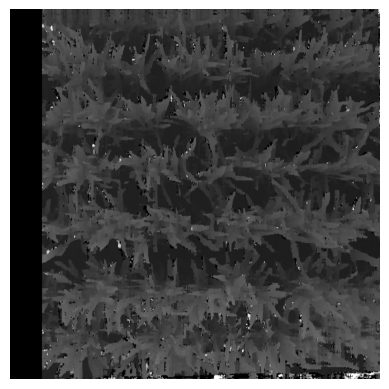

In [100]:
stereolib.display_images([name_disparity_image])

In [101]:
print(f"Min disparity boundary : {min_disparity_init}")
print(f"Max disparity boundary : {max_disparity_init}")
print(f"Number of disparities : {num_disparities_init}")

Min disparity boundary : 108
Max disparity boundary : 254
Number of disparities : 160


### Question : why is there a black vertical stripe at the left of the disparity image ?

# Step 3 : Evaluating the matching quality by computing the Normalized Total Gradient (NTG) 

### References to the NTG paper :

&nbsp;
Authors : Chen, Shu-Jie & Shen, Hui-Liang & Li, Chunguang & Xin, John. (2017). 

&nbsp;
Title : Normalized Total Gradient : A New Measure for Multispectral Image Registration. 

&nbsp;
Journal : IEEE Transactions on Image Processing. PP. 1-1. 10.1109/TIP.2017.2776753. 


We compute the normalized total gradient to evaluate the matching quality : the principle is to compare and the left and the right-on-left mapped image obtained by applying disparity to each pixel.
The ntg value is normalized in the [0,1] interval ; a lower value means a good matching (generally around 0.2 / 0.3) and a higher one (above 0.5) a bad disparity map quality

- Disparity maps on maize and associated NTG :

<img src="static/ntg_maize.png" width="500"/>

- Disparity maps on wheat and associated NTG :

<img src="static/ntg_wheat.png" width="750"/>


In [102]:
# We compute NTG with donwsampled data, so that it is (much) faster.
# It underestimates a bit the value, but the trends are conserved.
ntg_value, difference_img, right_on_left = stereolib.normalized_total_gradient(rect_gray_img_left_dwns,
                                                                               disparity_map_dwns,
                                                                               rect_gray_img_right_dwns,
                                                                               min_disparity=min_disparity,
                                                                               max_disparity=max_disparity,
                                                                              )

# As (if) downsampling has been done, we have to resize and interpolate disparity map to original RGB images size
difference_img = cv.resize(difference_img, (width-max_disparity, height), cv.INTER_LINEAR_EXACT)
right_on_left = cv.resize(right_on_left, (width-max_disparity, height), cv.INTER_LINEAR_EXACT)


# Save those images
name_left_img = path_outputs / "ntg_left_image.png"
name_difference_img = path_outputs / "ntg_difference_image.png"
name_right_on_left_img = path_outputs / "ntg_right_on_left_image.png"

stereolib.write_image(name_left_img, rect_gray_img_left[:, max_disparity:])
stereolib.write_image(name_difference_img, difference_img)
stereolib.write_image(name_right_on_left_img, right_on_left)

### Ouptuts :

Left image | right-on-left mapped image | difference image

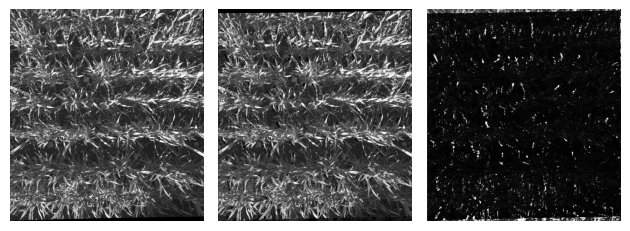

In [103]:
stereolib.display_images([name_left_img, name_right_on_left_img, name_difference_img])

In [104]:
print(f"NTG = {ntg_value}")

NTG = 0.2987168279538642


# Step 4 : Reprojecting the image pixels to 3D coordinates

We knew how to project a 3D point in the image 2D plane from the intrinsics matrix, but without the Z information, we were not able to perform the reverse operation :

&nbsp;
=> The projected point might be P1, or P2, or anywhere else on the optical way

Associating the disparity(x,y) value (= the distance information) to a pixel p(x,y) allows to remove the ambiguity and to find its correct position P=(X,Y,Z)

<img src="static/reprojection.png" width="750"/>

In [105]:
# 3 channels image containing (X, Y, Z) coordinates in mm of each pixel (in the rectified left reference frame)
xyz_image = cv.reprojectImageTo3D(disparity_map, Q_rect_left, handleMissingValues=False)

# Crop the left stripe corresponding to max disparity (closest pixels not seen in the right image) in the 3 images that need to be coregistered
# Here you could choose not to work on the full image, but on a central cropped zone for example, or on a masked region (if you have a vegetation
# segmentation mask generated from the RGB left image for example ; in this case, be careful to correctly rectify your mask as was done with the
# left RGB image, so that it's correctly coregistered with your left RGB image)
rect_img_left = rect_img_left[:, max_disparity:]
disparity_map = disparity_map[:, max_disparity:]
xyz_image = xyz_image[:, max_disparity:]

# We get the Z coordinates image and store it in a new variable
depth_image = xyz_image[:,:,2]

# We choose a step of 1 cm, which seems a be a correct compromise considering the acquisition system and context.
hist_range = int((np.max(depth_image) - np.min(depth_image)) / 10.)

# We compute the full depth_array histogram, without any filtering
depth_hist, depth_bins = np.histogram(depth_image, bins=hist_range)

### Outputs : 

Depth distribution from the sensor

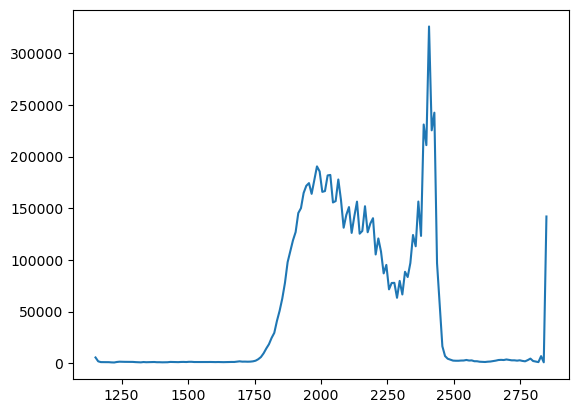

In [106]:
plt.plot(depth_bins[1:], depth_hist)

# Step 5 : Filtering the depth image by the 3D approach

At this step, we propose to take advantage of the 3D information we get to filter the imperfections that were generated at the stereo matching step

Using open3d,  it’s easy to put the (X,Y,Z) 3-channels image obtained at the previous step, together with the RGB pixel values, as they are all coregistered in the recitifed coordinate system of the left camera

Open3d gives access to several tools for filtering pointclouds, and the results are really satisfactory

In [107]:
# To remove erratic remaining points that may lead to bad soil distance estimation or plant height estimation, we will work with the 3D point cloud
# for an optimal filtering efficiency

# Copy the original (X,Y,Z) point cloud before downsampling
xyz_dwn_filtered = (np.copy(xyz_image).reshape(-1, 3).astype(np.float64))

# Keep only the valid Z values, i.e. positive ones (negative values dued to invalid disparity set to -1

# Pixels for which no correspondence has been found are set to 'min_disparity-1' by the SGBM algorithm.
# We compute the corresponding depth
infinite_depth = stereolib.compute_depth_from_disparity(baseline, focal_length, min_disparity-1)
# OR
# The supposed max valid depth values correspond to 'min_disparity'
# To be more selective, we'd rather choose to remove depth values above the max depth value
max_depth = stereolib.compute_depth_from_disparity(baseline, focal_length, min_disparity)
# We round max_depth to the digit above to ensure we keep all the valid values and not invalid ones
max_depth = int(max_depth) + 1

# We keep only strictly inferior values to max_depth either infinite_depth
valid_z_values, = np.where(xyz_dwn_filtered[:, 2] < infinite_depth)

# Copy the original (R,G,B) point cloud before downsampling
rgb_left_dwn_filtered = (np.copy(rect_img_left).reshape(-1, 3).astype(np.float64))

# Convert 3 channels (X,Y,Z) image into a Open3D point cloud 
pcd_xyz = o3d.geometry.PointCloud()
pcd_xyz.points = o3d.utility.Vector3dVector(xyz_dwn_filtered[valid_z_values])

# Convert 3 channels (R,G,B) image into a Open3D point cloud 
pcd_rgb = o3d.geometry.PointCloud()
pcd_rgb.points = o3d.utility.Vector3dVector(rgb_left_dwn_filtered[valid_z_values])

# Downsampling factor for the point cloud (saves time and memory)
ptcld_downsampling_factor = 12

# Downsample original (X,Y,Z) point cloud for computation gain
pcd_xyz_dwn = pcd_xyz.uniform_down_sample(every_k_points=ptcld_downsampling_factor)

# Downsample corresponding (R,G,B) point cloud the same way
pcd_rgb_dwn = pcd_rgb.uniform_down_sample(every_k_points=ptcld_downsampling_factor)

# Convert the (X,Y,Z) point cloud and corresponding (R,G,B) point cloud into classical numpy arrays for filtering
xyz_dwn_filtered = np.array(pcd_xyz_dwn.points)
rgb_left_dwn_filtered = np.array(pcd_rgb_dwn.points)

# Nb of neighbours for filtering
nb_of_neighbors = 256
# Standard deviation for filtering
std_ratio = 0.05

# Filter X,Y,Z point cloud ; returns the filtered X,Y,Z point cloud and the vector containing the indices of remaining valid points 
# in the original point cloud
pcd_filtered, valid_pixels_array = pcd_xyz_dwn.remove_statistical_outlier(nb_neighbors=nb_of_neighbors, std_ratio=std_ratio)

# Keep only the valid points in the (X,Y,Z) and corresponding (R,G,B) point cloud
xyz_dwn_filtered = xyz_dwn_filtered[valid_pixels_array]
rgb_left_dwn_filtered = rgb_left_dwn_filtered[valid_pixels_array]

# Name of the point cloud to be written
point_cloud_name = path_outputs / "pointcloud.laz"

# xyz_dwn_filtered = xyz_dwn_filtered[veg_mask_dwn_filtered>0]
# rgb_left_dwn_filtered = rgb_left_dwn_filtered[veg_mask_dwn_filtered>0]
stereolib.write_point_cloud(point_cloud_name, xyz_dwn_filtered, rgb_left_dwn_filtered)

### Outputs :

Here is the illustration of the efficiency of the 3D filtering

<img src="static/filtered_pointcloud.png" width="750"/>

# Step 6 : Estimating the mean height of the plants with a basic method

The height of a plant is basically the distance between the ground and its top

- By having access to the depth array, we can try to estimate the ground and the top of the canopy distances

- By calculating the difference of these distances, we should retrieve the height of the plants

<img src="static/plant_height.png" width="300"/>



## 1.  Estimation of the ground depth

 ### Outputs :

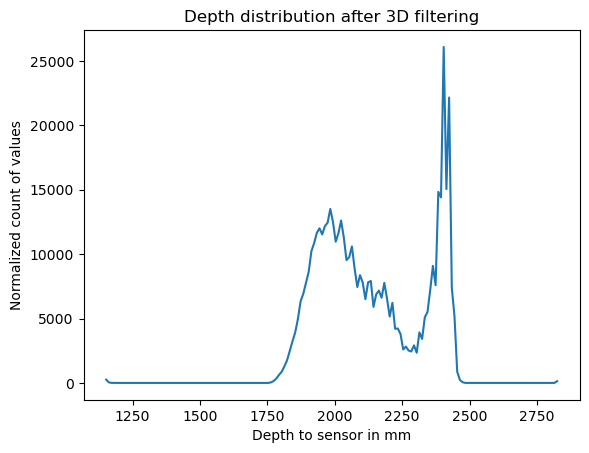

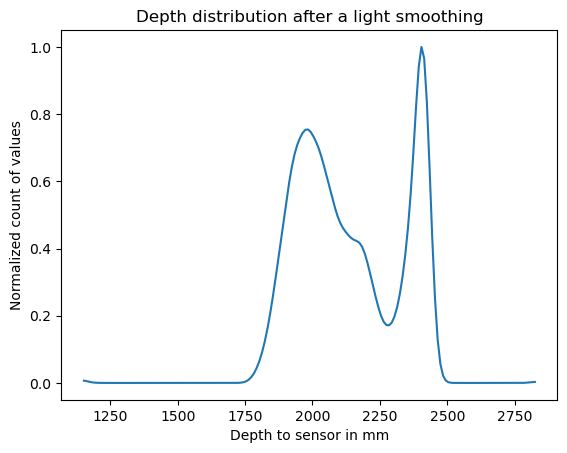

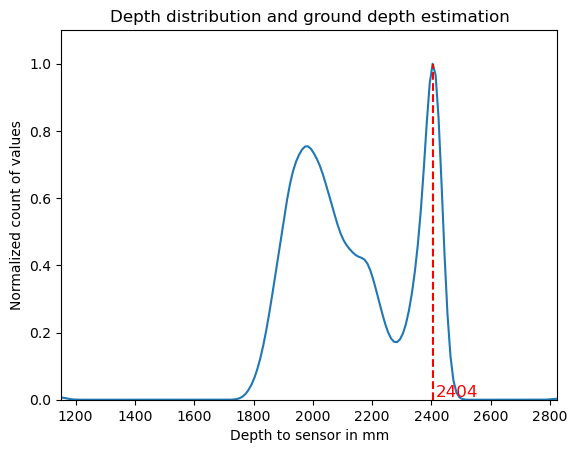

In [108]:
# Get the third channel of the (X,Y,Z) filtered downsampled array (float32 values, in mm), corresponding to z values, i.e. depth_image to sensor
depth_array = xyz_dwn_filtered[:, 2]

# Convert the floating values into rounded integer values (mm precision is more than what is reasonably achievable).
depth_array = np.round(depth_array).astype(np.uint32)

# Plot the depth_array histogram

# We choose a step of 1 cm, which seems a be a correct compromise considering the acquisition system and context.
hist_range = int((np.max(depth_array) - np.min(depth_array)) / 10.)

# We compute the depth_array histogram 
depth_hist, depth_bins = np.histogram(depth_array, bins=hist_range)
#depth_hist, depth_bins = np.histogram(depth_array, bins=10)

# We create a new figure
fig, ax = plt.subplots()

# Name of the horizontal axis
ax.set_xlabel('Depth to sensor in mm')
# Name of the vertical axis
ax.set_ylabel('Normalized count of values')

# Name of the plot
ax.set_title("Depth distribution after 3D filtering")

# Plot the histogram
plt.plot(depth_bins[1:], depth_hist)

# Smooth the histogram to remove micropeaks
filtered_depth_hist = gaussian_filter1d(depth_hist, sigma=2)

# We normalize the histogram
norm_filtered_depth_hist = filtered_depth_hist / np.max(filtered_depth_hist)

# We create a new figure
fig, ax = plt.subplots()

# Name of the horizontal axis
ax.set_xlabel('Depth to sensor in mm')
# Name of the vertical axis
ax.set_ylabel('Normalized count of values')

# Name of the plot
ax.set_title("Depth distribution after a light smoothing")

# We plot the filtered depth histogram
plt.plot(depth_bins[1:], norm_filtered_depth_hist)
#plt.savefig(path_outputs / Path('filtered_depth_hist.png'))

# We look for peaks into the depth histogram. In the favourable case (such this one) where soil is not so masked by the vegetation, 
# we can assume that the last peak corresponds to the ground level.
# The function returns peaks indices in the array, if any was found
peaks, _ = find_peaks(norm_filtered_depth_hist, height=0.1)

# We display the depths corresponding to the peaks indices
depth_bins[peaks+1]

# We assign the depth of the last peak to our ground estimated value
ground_depth = 0
if len(peaks) > 0:
    ground_depth = depth_bins[peaks[-1]+1]

ground_depth = np.round(ground_depth).astype(np.uint32)

# We create a new figure
fig, ax = plt.subplots()

# We plot once again the filtered depth histogram
plt.plot(depth_bins[1:], norm_filtered_depth_hist)

# Margins and limits of the plot
ax.margins(x=0, y=0)
ax.set_ylim(0, 1.1)

# We plot the vertical line corresponding to the ground estimated depth
plt.vlines(ground_depth, 0,1, linestyles='dashed', color='r')

# We annotate the line with appropriate value
ax.annotate(f'{ground_depth}', xy=(ground_depth, 0), xytext=(2, 0),
            textcoords='offset points',
            ha='left', va='bottom',
            fontsize=12, color='red')

# Name of the horizontal axis
ax.set_xlabel('Depth to sensor in mm')
# Name of the vertical axis
ax.set_ylabel('Normalized count of values')

# Name of the plot
ax.set_title("Depth distribution and ground depth estimation")

plt.savefig(path_outputs / Path('filtered_depth_hist.png'))

In [109]:
print(f"Ground depth estimation = {(ground_depth)} mm")

Ground depth estimation = 2404 mm


### Checking

Let's have a look at the information we can retrieve picking a soil point in our pointcloud 
(Made with CloudCompare)

<img src="static/read_soil.png" width="400"/>

## 2.  Estimation of the mean height of the plants

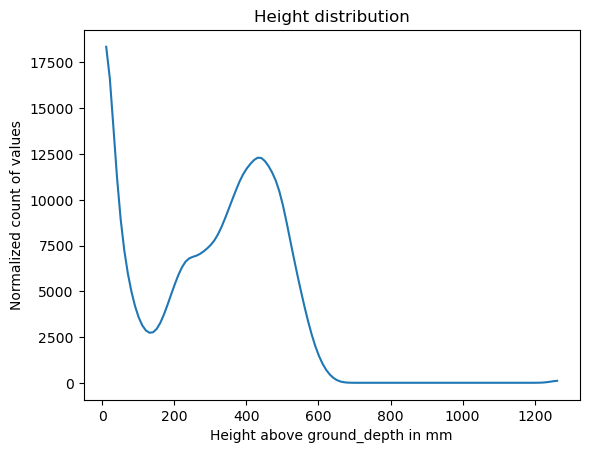

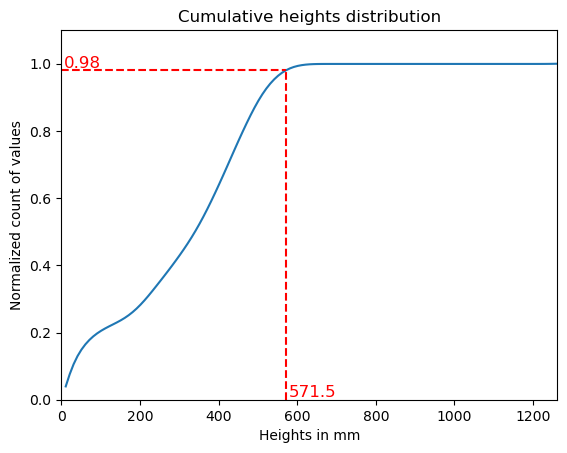

In [110]:
# Heigths may then be simply estimated by calculating the difference between the ground distance and the distances to objects
height_array = ground_depth - depth_array

# We ensure that there won't be values out of the expected range
height_array = height_array[height_array > 0]
height_array = height_array[height_array < ground_depth]

# We choose a step of 1 cm, which seems a be a correct compromise considering the acquisition system and context.
hist_range = int((np.max(height_array) - np.min(height_array)) / 10.)

# We compute the height histogram
height_hist, height_bins = np.histogram(height_array, bins=hist_range)

# Smooth the histogram to remove micropeaks, just as we did with depth
filtered_height_hist = gaussian_filter1d(height_hist, sigma=2)

# We create a new figure
fig, ax = plt.subplots()

# Name of the horizontal axis
ax.set_xlabel('Height above ground_depth in mm')
# Name of the vertical axis
ax.set_ylabel('Normalized count of values')

# Name of the plot
ax.set_title("Height distribution")

# We plot the histogram
plt.plot(height_bins[1:], filtered_height_hist)
plt.savefig(path_outputs / Path('filtered_height_hist.png'))

# We compute the cumulative height distribution
cumulative_height_distribution = np.cumsum(filtered_height_hist)

# We normalize it so that valus are int the interval [0,1]
cumulative_height_distribution = cumulative_height_distribution / np.max(cumulative_height_distribution)

# We define the desired percentile of the distribution, that will lead to a consistent height value (for wheat), 
# based on many comparisons with manual height measurements.
percentile = 0.98

# We keep only height values that are above this percentile
mean_height_array, = np.where(cumulative_height_distribution >= percentile)

# We retrieve the first value and define it as the mean height
mean_height = height_bins[mean_height_array[0]+1]

# We create a new figure
fig, ax = plt.subplots()

# We plot the cumulative heights histogram
plt.plot(height_bins[1:], cumulative_height_distribution)

# We plot the horizontal line corresponding to the desired percentile (98%) of the the height cumulative distribution count 
plt.hlines(0.98, 0, mean_height, linestyles='dashed', color='r')

# We annotate the line with appropriate value
ax.annotate(f'0.98', xy=(0, 0.98), xytext=(2, 0),
            textcoords='offset points',
            ha='left', va='bottom',
            fontsize=12, color='red')

# We plot the vertical line where the desired percentile (98%) is reached in the cumulative distribution
plt.vlines(mean_height, 0, 0.98, linestyles='dashed', color='r')

# We annotate the line with appropriate value
ax.annotate(f'{mean_height:.1f}', xy=(mean_height, 0), xytext=(2, 0),
            textcoords='offset points',
            ha='left', va='bottom',
            fontsize=12, color='red')

# Margins and limits of the plot
ax.margins(x=0, y=0)
ax.set_ylim(0, 1.1)

# Name of the horizontal axis
ax.set_xlabel('Heights in mm')
# Name of the vertical axis
ax.set_ylabel('Normalized count of values')

# Name of the plot
ax.set_title("Cumulative heights distribution")

plt.savefig(path_outputs / Path('cumulative_height_distribution.png'))

In [111]:
print(f"Plant mean height estimation = {int(mean_height)} mm")

Plant mean height estimation = 571 mm


### Checking

Let's have a look at the information we can retrieve picking a soil point in our pointcloud 
(Made with CloudCompare)

<img src="static/read_height.png" width="400"/>

### Generating the height image


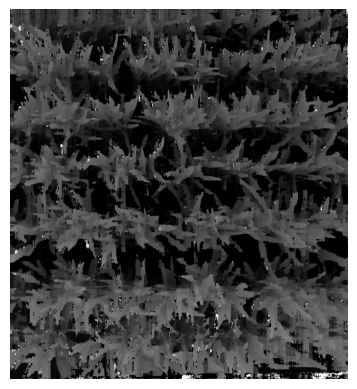

In [112]:
# We can go back to the non-filtered depth image to have a representation of the heights of objects in the image, 
# Distances are in mm in depth_image ; we divide those values by 10, so that we get the heights with a cm precision in a 8 bits image
# (values between 0 and 255 cm)
height_image = ((ground_depth - depth_image) / 10.)

height_image[height_image < 0] = 0
height_image[height_image > 255] = 0 

height_image = height_image.astype(np.uint8)

name_height_image = path_outputs / "height.png"

stereolib.write_image(name_height_image, height_image)

stereolib.display_images([name_height_image])

In [113]:
height_image.shape

(3100, 2833)